# **Importing Libraries**

In [1]:
%pip install git+https://github.com/AIcrowd/coco.git#subdirectory=PythonAPI 
#quite interestingly if not imported and used the later version present in the colab enviroment not all the data in the dataset will be seen

  Cloning https://github.com/AIcrowd/coco.git to /tmp/pip-req-build-7c5u1wnz
  Running command git clone -q https://github.com/AIcrowd/coco.git /tmp/pip-req-build-7c5u1wnz
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263852 sha256=a3f581d6b501f8086f8711727cc72f5c90257634f642858b8a8b566e16d415f7
  Stored in directory: /tmp/pip-ephem-wheel-cache-hg4sb_jl/wheels/ab/90/04/967e938726d585d7f0cdf0522611965b7e138f6cd9a6937b35
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2


In [2]:
%pip install -U --pre segmentation-models

     |████████████████████████████████| 51kB 7.0MB/s 


In [3]:
import numpy as np
import tensorflow as tf

from keras import backend as K

import keras.engine as KE

from keras import layers as KL
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,Multiply
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose

from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from tensorflow.keras import initializers
from tensorflow import image

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import random

import cv2

import skimage.io as io

from google.colab import drive
from pycocotools import mask as cocomask

import os
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


# **Loading the data**

In [5]:
from pycocotools.coco import COCO

#Loading the coco annotations
folder_loc = "/content/drive/MyDrive/segmentation_food"

coco_train = COCO(folder_loc + '/train/annotations.json')
coco_val = COCO(folder_loc + '/val/annotations.json')

loading annotations into memory...
Done (t=6.37s)
creating index...
index created!
loading annotations into memory...
Done (t=1.43s)
creating index...
index created!



# **Exploring the data**

In [6]:
def plot_image(image_id, coco, mode='train'):
    #read the image
    img = coco.loadImgs(image_id)[0]
    image = mpimg.imread(folder_loc + '/' + mode + '/images/' + img['file_name'])
    
    #display image
    img_plot = plt.imshow(image)
    
    #loading image id
    annotations = coco.loadAnns(coco.getAnnIds(imgIds=image_id))

    for i in range(len(annotations)):
        #different color for different annotations
        colors = ['b', 'c', 'r', 'g', 'm', 'y', 'k'][i]
        ann = annotations[i]

        #plotting segmentation
        for seg in ann['segmentation']:
            plt.fill(seg[0::2], seg[1::2], colors, alpha=0.4)
            plt.fill(seg[0::2], seg[1::2], colors, alpha=0.8)
  
    #show results
    plt.show()

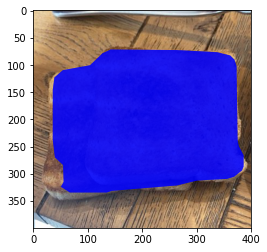

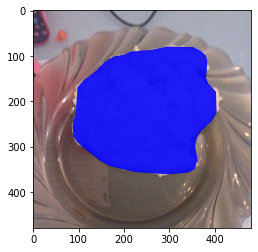

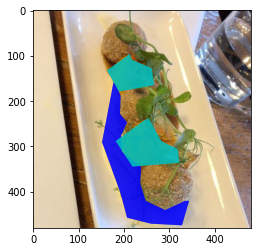

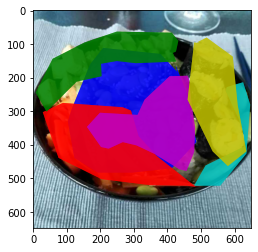

[78968, 59793, 30544, 26644]


In [7]:
np.random.seed(100)
img_num = []
rand = np.random.randint(0, len(coco_train.getImgIds()), 4)
for i in rand:
    img_num.append(coco_train.getImgIds()[i])
for ids in img_num:
    plot_image(ids, coco_train)
print(img_num)


# **Loading and cleaning the data**


In [8]:
def get_ordered_ids():
    catIds_raw = coco_train.getCatIds()
    catIds = []
    for cat in catIds_raw:
          catIds.append([len(coco_train.getImgIds(catIds=cat)), cat])
    catIds.sort()
    cat_ids = [cat_num[1] for cat_num in catIds ]
    return cat_ids

In [9]:
# display COCO categories
categories = coco_train.loadCats(get_ordered_ids())
classes=[cat['name'] for cat in categories]
number_of_classes = len(classes)
print('COCO categories: ', number_of_classes)

COCO categories:  273


# **Defining functions to manage the dataset**






Function to filter the dataset

In [10]:
def filterDataset(folder, mode, classes=None):    
    # initialize COCO api for instance annotations
    annFile = '{}/{}/annotations.json'.format(folder, mode)
    coco = COCO(annFile)
    
    images = []

    if classes!=None:
        # iterate for each individual class in the list
        for className in classes:
            # get all images containing given categories
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
    
    else:
      imgIds = coco.getImgIds()
      images = coco.loadImgs(imgIds)
    
    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    
    return unique_images, dataset_size, coco


Function to create the masks




In [11]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

def getImage(imageObj, img_folder, input_image_size):
    # Read and normalize an image
    train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img
    
def getNormalMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        #Assign to the pixel the value of the class
        pixel_value = classes.index(className)+1
        #The annToMask method returns a binary mask. 
        #Multipling the mask of that class by the pixel_value we assign that value to each of the pixels  
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
        #With np.maximum we join all the masks of different classes into a single one
        #The classes are sorted by popularity in descending order, so the mask of the most popular classes will prevail on the others
        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask  

def getBinaryMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    n_classes = len(classes) + 1
    train_mask = np.zeros((input_image_size[0], input_image_size[1], n_classes))
    for i in range(len(anns)):
        #Get the index of the class
        className = getClassName(anns[i]['category_id'], cats)
        class_index = classes.index(className) + 1

        #If the index of the class is equal to the index iterating through the annotation add the
        #binary mask to the array
        
        new_mask = cv2.resize(coco.annToMask(anns[i]), input_image_size)
        #Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0
        train_mask[:,:,class_index] = new_mask

    #Adding background mask into the training mask in position 0
    food_mask = np.argmax(train_mask, axis=2)
    background_mask = (np.logical_not(food_mask)).astype(int)
    train_mask[:,:,0] = background_mask
    
    return train_mask


In [12]:

def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

def getImage(imageObj, img_folder, input_image_size):
    # Read and normalize an image
    train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img
    
def getNormalMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        #Assign to the pixel the value of the class
        pixel_value = classes.index(className)+1
        #The annToMask method returns a binary mask. 
        #Multipling the mask of that class by the pixel_value we assign that value to each of the pixels  
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
        #With np.maximum we join all the masks of different classes into a single one
        #The classes are sorted by popularity in descending order, so the mask of the most popular classes will prevail on the others
        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask  

def getBinaryMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    n_classes = len(classes) + 1
    train_mask = np.zeros((input_image_size[0], input_image_size[1], n_classes))
    for i in range(len(anns)):
        #Get the index of the class
        className = getClassName(anns[i]['category_id'], cats)
        class_index = classes.index(className) + 1

        #If the index of the class is equal to the index iterating through the annotation add the
        #binary mask to the array
        
        new_mask = cv2.resize(coco.annToMask(anns[i]), input_image_size)
        #Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0
        train_mask[:,:,class_index] = new_mask

    #Adding background mask into the training mask in position 0
    food_mask = np.argmax(train_mask, axis=2)
    background_mask = (np.logical_not(food_mask)).astype(int)
    train_mask[:,:,0] = background_mask
    
    return train_mask

Data generators

In [13]:
def dataGeneratorCoco(images, classes, coco, folder, 
                      input_image_size, batch_size, mode, mask_type):
    
    img_folder = '{}/{}/images'.format(folder, mode)
    dataset_size = len(images)
    #catIds = get_category_ids()
    catIds = coco.getCatIds(catNms=classes)
    n_classes = len(classes) + 1
    
    c = 0
    while(True):
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        #mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')
        mask =np.zeros((batch_size, input_image_size[0], input_image_size[1], n_classes))
        Bbox=np.zeros((batch_size,n_classes-1,4)).astype('float')
        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
            imageObj = images[i]
            
            ### Retrieve Image ###
            train_img = getImage(imageObj, img_folder, input_image_size)
            
            ### Create Mask ###
            if mask_type=="binary":
                train_mask = getBinaryMask(imageObj, classes, coco, catIds, input_image_size)
            
            elif mask_type=="normal":
                train_mask = getNormalMask(imageObj, classes, coco, catIds, input_image_size)                
            
            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask
            #transforming the binary mask to bounding box
            Bbox[i-c]= cocomask.toBbox(cocomask.encode(np.asfortranarray(mask[i-c]).astype(np.uint8)))[1:]
            Areas=Bbox[i-c,:,2]*Bbox[i-c,:,3]
            #avoinding 0 areas Bounding Boxes 
            Areas[Areas==0]=1
            order=np.argsort(np.sum(mask[i-c,:,:,1:],axis=(0,1))/(Areas))
            first=Bbox[i-c]

            second=np.copy(first)
            #converting from the notation of coco [x,y,width,height] to notation used by tensorflow [y,x,y2,x2] opposing corners of the Bounding boxes
            first[:,0],first[:,1],first[:,2],first[:,3]=second[:,1],second[:,0],second[:,3],second[:,2]
            first[:,2:]=first[:,:2]
            second[:,:2]=0
            #ordering bounding box by number of active pixel /area of the bounding box in pixel
            Bbox[i-c]=(first+second)[order]/input_image_size[0]
        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)
        yield img, [mask,Bbox[:,-1,:]]

In [23]:
def visualizeGenerator(gen):
    # Iterate the generator to get image and mask batches
    img, mask = next(gen)
    mask=mask[0]
    n_classes = len(classes) + 1
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)
   
    for i in range(2):        
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)
        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j]);
            else:
                final_mask = np.zeros((input_image_size[0], input_image_size[1]))
                for i in range(1, n_classes):
                    color = i + 1
                    new_mask = mask[j][:,:,i]*color
                    final_mask = np.maximum(new_mask, final_mask)
                ax.imshow(final_mask);
            ax.axis('off')
            fig.add_subplot(ax)
    plt.show()

# **Filtering the dataset and defining the generators**

In [14]:
classes = ['water', 'bread-white', 'salad-leaf-salad-green', 'tomato', 'butter', 'bread-wholemeal', 'carrot', 'rice', 'egg', 'mixed-vegetables', 'wine-red', 'apple', 'jam', 'potatoes-steamed', 'banana', 'cheese']
images_train, dataset_size_train, coco_train = filterDataset(folder_loc,'train',classes)

loading annotations into memory...
Done (t=2.40s)
creating index...
index created!


In [15]:
images_val, dataset_size_val, coco_val = filterDataset(folder_loc,'val',classes)

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


In [16]:
print("The training set size is:", dataset_size_train)
print("The validation set size is:", dataset_size_val)

The training set size is: 10453
The validation set size is: 539


In [17]:
batch_size = 8
input_image_size = (128,128)
mask_type = 'binary'

train_gen = dataGeneratorCoco(images_train, classes, coco_train, folder_loc,
                            input_image_size, batch_size, 'train', mask_type)

val_gen = dataGeneratorCoco(images_val, classes, coco_val, folder_loc,
                            input_image_size, batch_size, 'val', mask_type)

# **Display binary masks**

In [18]:
def display_binary_masks(mask):
  
  n_classes = len(classes) + 1
  plt.figure(figsize=(25, 5))
  display_classes = ['background'] + classes

  for i in range(n_classes):
      color = i + 1
      new_mask = mask[:,:,i]*color
      plt.subplot(2,9,i+1)
      plt.title(display_classes[i])
      plt.axis('off')
      plt.imshow(new_mask)

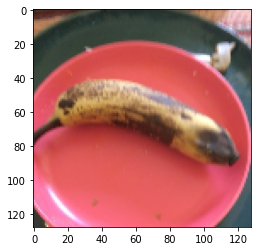

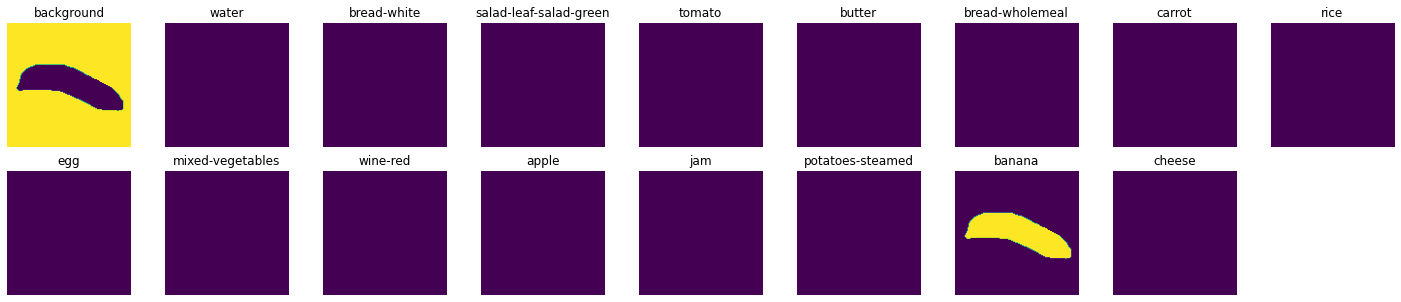

In [21]:
image_id = 11
img_folder = '{}/{}/images'.format(folder_loc, 'train')
train_img = getImage(images_train[image_id], img_folder, input_image_size)
catIds = coco_train.getCatIds(catNms=classes)
mask = getBinaryMask(images_train[image_id], classes, coco_train, catIds, input_image_size)
plt.imshow(train_img)
display_binary_masks(mask)

# **Visualize the masks**

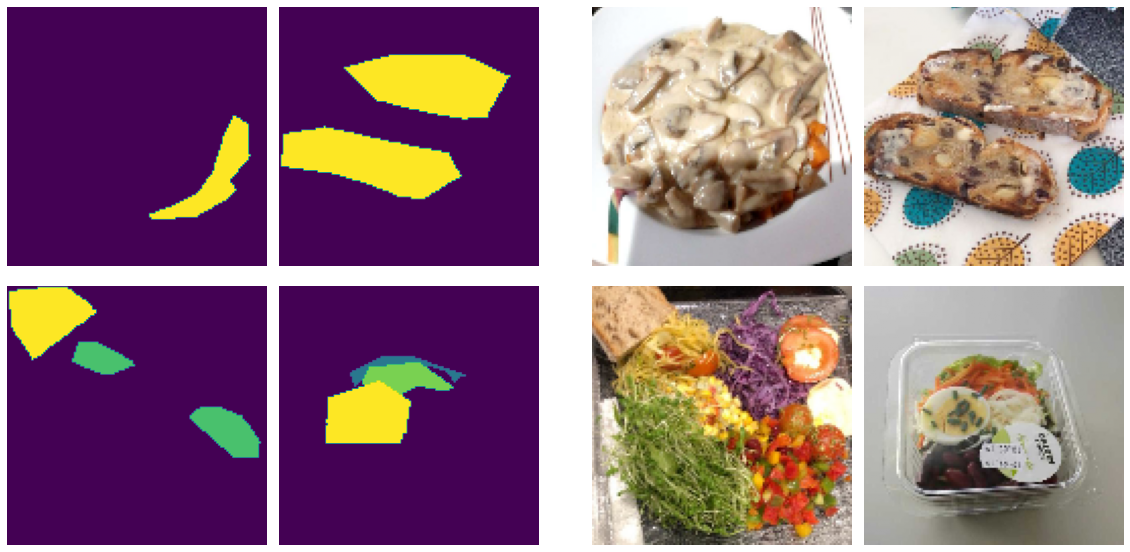

In [24]:
visualizeGenerator(train_gen)

In [19]:
img, mask = next(train_gen)
print("The shape of the image batch is: ", img.shape)
print("The shape of the mask batch is: ", mask[0].shape)

The shape of the image batch is:  (8, 128, 128, 3)
The shape of the mask batch is:  (8, 128, 128, 17)


# **Data augmentation**

In [20]:
def augmentationsGenerator(gen, augGeneratorArgs, seed=None):
    # Initialize the image data generator with args provided
    image_gen = ImageDataGenerator(**augGeneratorArgs)
    
    # Remove the brightness argument for the mask. Spatial arguments similar to image.
    augGeneratorArgs_mask = augGeneratorArgs.copy()
    _ = augGeneratorArgs_mask.pop('brightness_range', None)
    # Initialize the mask data generator with modified args
    mask_gen = ImageDataGenerator(**augGeneratorArgs_mask)
    
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))

    n_classes = len(classes)

    for img, mask in gen:

        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation of the images 
        # will end up different from the augmentation of the masks
        g_x = image_gen.flow(255*img, 
                             batch_size = img.shape[0], 
                             seed = seed, 
                             shuffle=True)
        
        g_y = mask_gen.flow((mask[0],mask[1]), 
                             batch_size = mask[0].shape[0], 
                             seed = seed, 
                             shuffle=True)
        
        

        img_aug = next(g_x)/255.0
        
        mask_aug,Bbox = next(g_y)
        
        yield img_aug, [mask_aug,Bbox]

In [21]:
augGeneratorArgs = dict(featurewise_center = False, 
                        samplewise_center = False,
                        rotation_range = 5, 
                        width_shift_range = 0.01, 
                        height_shift_range = 0.01, 
                        brightness_range = (0.8,1.2),
                        shear_range = 0.01,
                        zoom_range = [1, 1.25],  
                        horizontal_flip = True, 
                        vertical_flip = False,
                        fill_mode = 'reflect',
                        data_format = 'channels_last')

train_gen_aug = augmentationsGenerator(train_gen, augGeneratorArgs)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (8, 128, 128, 17) (17 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


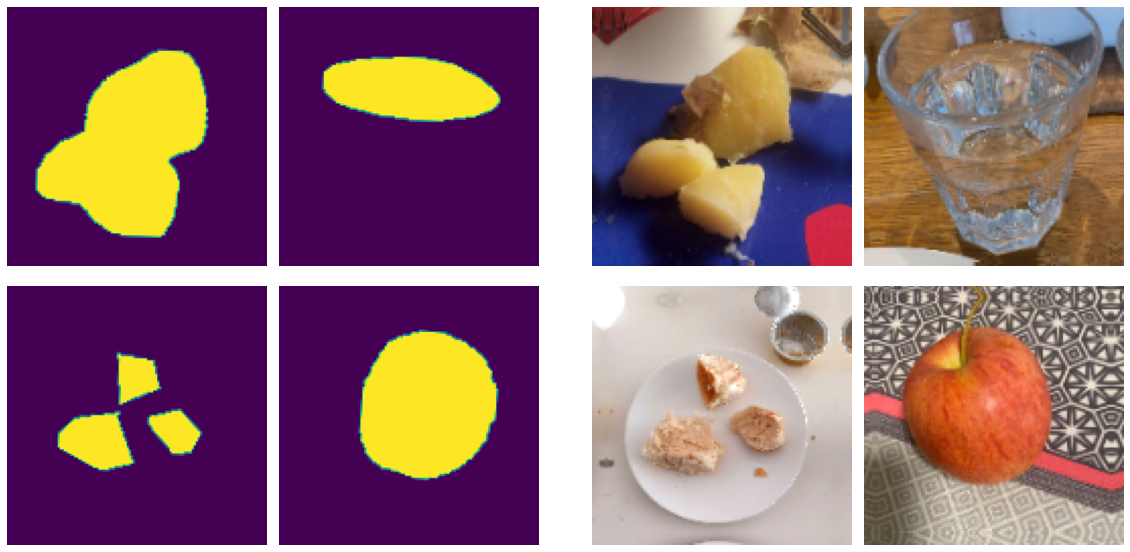

In [25]:
visualizeGenerator(train_gen_aug)

# **Building model architecture**


Useful functions

In [26]:
def compute_backbone_shapes(image_shape):
   return np.array(
        [[int(math.ceil(image_shape[0] / stride)),
            int(math.ceil(image_shape[1] / stride))]
            for stride in [4, 8, 16, 32, 64]])

In [28]:
from utilis import compute_backbone_shapes,generate_anchors,generate_pyramid_anchors,norm_boxes,get_anchors,batch_slice

# **Defining Blocks for Res_Net model**

In [29]:
def identity_block(input_tensor, kernel_size, filters, stage, block,
                   use_bias=True, train_bn=True):
    """The identity_block is the block that has no conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        use_bias: Boolean. To use or not use a bias in conv layers.
        train_bn: Boolean. Train or freeze Batch Norm layers
    """
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = KL.Conv2D(nb_filter1, (1, 1), name=conv_name_base + '2a',
                  use_bias=use_bias)(input_tensor)
    x = BatchNormalization(name=bn_name_base + '2a')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same',
                  name=conv_name_base + '2b', use_bias=use_bias)(x)
    x = BatchNormalization(name=bn_name_base + '2b')(x, training=train_bn)
    x = KL.Activation('relu')(x)

    x = KL.Conv2D(nb_filter3, (1, 1), name=conv_name_base + '2c',
                  use_bias=use_bias)(x)
    x = BatchNormalization(name=bn_name_base + '2c')(x, training=train_bn)

    x = KL.Add()([x, input_tensor])
    x = KL.Activation('relu', name='res' + str(stage) + block + '_out')(x)
    return x

In [30]:
def conv_block(input_tensor, kernel_size, filters, stage, block,
               strides=(2, 2), use_bias=True, train_bn=True):
    """conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the nb_filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        use_bias: Boolean. To use or not use a bias in conv layers.
        train_bn: Boolean. Train or freeze Batch Norm layers
    Note that from stage 3, the first conv layer at main path is with subsample=(2,2)
    And the shortcut should have subsample=(2,2) as well
    """
    nb_filter1, nb_filter2, nb_filter3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    x = KL.Conv2D(nb_filter1, (1, 1), strides=strides,
                  name=conv_name_base + '2a', use_bias=use_bias)(input_tensor)
    x = KL.BatchNormalization(name=bn_name_base + '2a')(x, training=train_bn)
    
    x = KL.Activation('relu')(x)
    
    x = KL.Conv2D(nb_filter2, (kernel_size, kernel_size), padding='same',
                  name=conv_name_base + '2b', use_bias=use_bias)(x)
    x = BatchNormalization(name=bn_name_base + '2b')(x, training=train_bn)
    
    x = KL.Activation('relu')(x)
    
    x = KL.Conv2D(nb_filter3, (1, 1), name=conv_name_base +
                  '2c', use_bias=use_bias)(x)
    x = BatchNormalization(name=bn_name_base + '2c')(x, training=train_bn)

    shortcut = KL.Conv2D(nb_filter3, (1, 1), strides=strides,
                         name=conv_name_base + '1', use_bias=use_bias)(input_tensor)
    shortcut = BatchNormalization(name=bn_name_base + '1')(shortcut, training=train_bn)

    x = KL.Add()([x, shortcut])
    x = KL.Activation('relu', name='res' + str(stage) + block + '_out')(x)
    return x

In [31]:
def resnet_graph(input_image,train_bn):
  x = KL.ZeroPadding2D((3, 3))(input_image)
  
  x = KL.Conv2D(64, (7, 7), strides=(2, 2), name='conv1', use_bias=True)(x)
  
  x = BatchNormalization(name='bn_conv1')(x)
  x = KL.Activation('relu')(x)
  
  C1 = x = KL.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)
  
  x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1), train_bn=train_bn)
  
  x = identity_block(x, 3, [64, 64, 256], stage=2, block='b', train_bn=train_bn)
  
  C2 = x = identity_block(x, 3, [64, 64, 256], stage=2, block='c', train_bn=train_bn)
  
  x = conv_block(x, 3, [128, 128, 512], stage=3, block='a', train_bn=train_bn)
  x = identity_block(x, 3, [128, 128, 512], stage=3, block='b', train_bn=train_bn)
  x = identity_block(x, 3, [128, 128, 512], stage=3, block='c', train_bn=train_bn)
  C3 = x = identity_block(x, 3, [128, 128, 512], stage=3, block='d', train_bn=train_bn)
  
  x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a', train_bn=train_bn)
  block_count = 5
  
  for i in range(block_count):
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=chr(98 + i), train_bn=train_bn)
  C4 = x
  x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a', train_bn=train_bn)
  x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b', train_bn=train_bn)
  C5 = x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c', train_bn=train_bn)

  return [C1,C2,C3,C4,C5]

rpn function and Proposal layer

In [32]:
def apply_box_deltas_graph(boxes, deltas):
    """Applies the given deltas to the given boxes.
    boxes: [batch,N, (y1, x1, y2, x2)] boxes to update
    deltas: [batch,N, (dy, dx, log(dh), log(dw))] refinements to apply
    """
    # Convert to y, x, h, w
    height = boxes[:,:, 2] - boxes[:,:, 0]
    width = boxes[:,:, 3] - boxes[:,:, 1]
    center_y = boxes[:,:, 0] + 0.5 * height
    center_x = boxes[:,:, 1] + 0.5 * width
    # Apply deltas
    center_y += deltas[:,:, 0] * height
    center_x += deltas[:,:, 1] * width
    height *= tf.exp(deltas[:,:, 2])
    width *= tf.exp(deltas[:,:, 3])
    # Convert back to y1, x1, y2, x2
    y1 = center_y - 0.5 * height
    x1 = center_x - 0.5 * width
    y2 = y1 + height
    x2 = x1 + width
    result = tf.stack([y1, x1, y2, x2], axis=2, name="apply_box_deltas_out")
    return result
    
def clip_boxes_graph(boxes, window):
    """
    boxes: [N, (y1, x1, y2, x2)]
    window: [4] in the form y1, x1, y2, x2
    """
    # Split
    wy1, wx1, wy2, wx2 = tf.split(window, 4)
    y1, x1, y2, x2 = tf.split(boxes, 4, axis=2)

    # Clip
    y1 = tf.maximum(tf.minimum(y1, wy2), wy1)
    x1 = tf.maximum(tf.minimum(x1, wx2), wx1)
    y2 = tf.maximum(tf.minimum(y2, wy2), wy1)
    x2 = tf.maximum(tf.minimum(x2, wx2), wx1)
    clipped = tf.concat([y1, x1, y2, x2], axis=2, name="clipped_boxes")
    clipped.set_shape((*clipped.shape[0:2], 4))
    
    return clipped

In [ ]:
class ProposalLayer(KL.Layer):
    def __init__(self, proposal_count, nms_threshold, **kwargs):
        super(ProposalLayer, self).__init__(**kwargs)
        self.proposal_count = proposal_count
        self.nms_threshold = nms_threshold
    def call(self,inputs):
      scores = inputs[0]

      deltas = inputs[1]

      anchors = inputs[2]
     
     
      boxes = apply_box_deltas_graph(anchors, deltas)
      
    
      window = np.array([0, 0, 1, 1], dtype=np.float32)
      boxes = clip_boxes_graph(boxes, window)                         


      return boxes,scores
    def compute_output_shape(self, input_shape):
      return (None, self.proposal_count, 4)
                                      
'''
different trial layers which resulted in poor behaviours      
class Cropping_boxes(KL.Layer):
  def __init__(self, **kwargs):
    super(Cropping_boxes, self).__init__(**kwargs)
  @tf.function
  def call (self,inputs):
    B_boxes=inputs[0]
    images=inputs[1]
    def mltflt_int(a,b):
      return tf.cast(tf.cast(b,tf.float32)*a,tf.int32)
    @tf.function
    def padded_detail(i,j):
      y1=mltflt_int(B_boxes[i][j][0],images.shape[1]) 
      x1=mltflt_int(B_boxes[i][j][1],images.shape[2])
      y2=mltflt_int(B_boxes[i][j][2],images.shape[1])
      x2=mltflt_int(B_boxes[i][j][3],images.shape[2])                  
      return tf.image.pad_to_bounding_box(tf.image.crop_to_bounding_box(images[i],y1,x1,y2,x2),y1,x1,images.shape[1],images.shape[2])

    return tf.stack([padded_detail(i,j) for i in tf.range(0,tf.shape(images)[0]) for j in tf.range(0,tf.shape(B_boxes[i])[0]) ])
class Attention_box_generation(KL.Layer):
  def __init__(self,proposals_shape,filter_shape,n_rois, **kwargs):
    super(Attention_box_generation, self).__init__(**kwargs)
    self.shape_variable = filter_shape[1:3]
    
    self.d = tf.Variable(
            initial_value=tf.constant(1,shape=(1,),dtype="float32"),
            trainable=True,name='la fittizzia')
    self.ind = tf.Variable(
            initial_value=tf.constant(0,shape=(1,),dtype="float32"),
            trainable=True)

    
    self.block=tf.Variable(
            initial_value=tf.zeros(shape=(16,*filter_shape[1:]),dtype="float32"),
            trainable=False)
    
    
  @tf.function
  def call (self,inputs):
    
    
    
    #maschera=tf.zeros(shape=self.shape_variable)
    #mask to multiply based on the structure of the proposal boxes
    y1,y2,x1,x2=inputs[0]
    
    
   
    
    #maschera_np=maschera.numpy()
    #y1,y2,x1,x2=tf.cond(x2.shape[0]!=None,lambda:return [y1,y2,x1,x2],lambda:return[tf.constant(1,shape=(n_rois))])
    #tf.cond(tf.constant(x2.shape[0]!=None),lambda:a_vuoto(),lambda:tf.constant(0))
    for i in tf.range(0,tf.shape(x1)[0]):
      self.block[i].assign(tf.zeros(tf.shape(self.block)[1:],dtype=tf.float32))
    
      self.block[i,x1[i]:x2[i],y1[i]:y2[i]].assign(tf.ones(shape=(x2[i]-x1[i],y2[i]-y1[i],tf.shape(self.block)[-1])))
      self.block[i].assign((1-self.block[i])*self.ind + self.block[i]*self.d)
    
    
    tf.print('dove se impara qualcosa',tf.where(self.block[0:tf.shape(x1)[0]]>1))
    tf.print('dove 1',tf.where(self.block[0:tf.shape(x1)[0]]==1))
    tf.print('dove 0',tf.where(self.block[0:tf.shape(x1)[0]]==0))
    tf.print('dove ne uno ne altro',tf.where(tf.logical_and(self.block[0:tf.shape(x1)[0]]!=0,self.block[0:tf.shape(x1)[0]]!=1)))
 
    

    return self.block[0:tf.shape(x1)[0]]*inputs[1]
'''

In [34]:
def rpn_graph(feature_map, anchors_per_location, anchor_stride):
    """Builds the computation graph of Region Proposal Network.

    feature_map: backbone features [batch, height, width, depth]
    anchors_per_location: number of anchors per pixel in the feature map
    anchor_stride: Controls the density of anchors. Typically 1 (anchors for
                   every pixel in the feature map), or 2 (every other pixel).

    Returns:
        rpn_class_logits: [batch, H * W * anchors_per_location, 2] Anchor classifier logits (before softmax)
        rpn_probs: [batch, H * W * anchors_per_location, 2] Anchor classifier probabilities.
        rpn_bbox: [batch, H * W * anchors_per_location, (dy, dx, log(dh), log(dw))] Deltas to be
                  applied to anchors.
    """
    # TODO: check if stride of 2 causes alignment issues if the feature map
    # is not even.
    # Shared convolutional base of the RPN
    shared = KL.Conv2D(512, (3, 3), padding='same', activation='relu',
                       strides=anchor_stride,
                       name='rpn_conv_shared')(feature_map)
    
    # Anchor Score. [batch, height, width, anchors per location * 2].
    x = KL.Conv2D(2 * anchors_per_location, (1, 1), padding='valid',
                  activation='linear', name='rpn_class_raw')(shared)
   
    # Reshape to [batch, anchors, 2]
    rpn_class_logits = KL.Lambda(
        lambda t: tf.reshape(t, [tf.shape(t)[0], -1, 2]))(x)
   
    # Softmax on last dimension of BG/FG.
    rpn_probs = KL.Activation(
        "softmax", name="rpn_class_xxx")(rpn_class_logits)
    
    # Bounding box refinement. [batch, H, W, anchors per location * depth]
    # where depth is [x, y, log(w), log(h)]
    x = KL.Conv2D(anchors_per_location * 4, (1, 1), padding="valid",
                  activation='linear', name='rpn_bbox_pred')(shared) 
    
    # Reshape to [batch, anchors, 4]
    rpn_bbox = KL.Lambda(lambda t: tf.reshape(t, [tf.shape(t)[0], -1, 4]),name='lamda_bbox_pred')(x)
    return [rpn_class_logits, rpn_probs, rpn_bbox]

def build_rpn_model(anchor_stride, anchors_per_location, depth):
    """Builds a Keras model of the Region Proposal Network.
    It wraps the RPN graph so it can be used multiple times with shared
    weights.

    anchors_per_location: number of anchors per pixel in the feature map
    anchor_stride: Controls the density of anchors. Typically 1 (anchors for
                   every pixel in the feature map), or 2 (every other pixel).
    depth: Depth of the backbone feature map.

    Returns a Keras Model object. The model outputs, when called, are:
    rpn_class_logits: [batch, H * W * anchors_per_location, 2] Anchor classifier logits (before softmax)
    rpn_probs: [batch, H * W * anchors_per_location, 2] Anchor classifier probabilities.
    rpn_bbox: [batch, H * W * anchors_per_location, (dy, dx, log(dh), log(dw))] Deltas to be
                applied to anchors.
    """
    input_feature_map = KL.Input(shape=[None, None, depth],
                                 name="input_rpn_feature_map")
    outputs = rpn_graph(input_feature_map, anchors_per_location, anchor_stride)
    return Model([input_feature_map], outputs, name="rpn_model")

# **Building model**

In [35]:
def softargmax(x, beta=1e10):
  x = tf.convert_to_tensor(x)
  x_range = tf.range(x.shape.as_list()[-1], dtype=x.dtype)
  return tf.reduce_sum(tf.nn.softmax(x*beta) * x_range, axis=-1)
def build(num_classes,input_shape,train_bn=True):
  
  input_image = KL.Input(
            shape=input_shape, name="input_image")
  anchors = get_anchors(input_shape)
  anchors = [tf.broadcast_to(i, (tf.shape(input_image)[0], *(i.shape))) for i in anchors]
  
  _, C2, C3, C4, C5 = resnet_graph(input_image,train_bn)
 
  P5 = KL.Conv2D(128, (1, 1), name='fpn_c5p5')(C5)
  
  P4 = KL.Add(name="fpn_p4add")([
        KL.UpSampling2D(size=(2, 2), name="fpn_p5upsampled")(P5),
        KL.Conv2D(128, (1, 1), name='fpn_c4p4')(C4)])
  
  P3 = KL.Add(name="fpn_p3add")([
         KL.UpSampling2D(size=(2, 2), name="fpn_p4upsampled")(P4),
         KL.Conv2D(128, (1, 1), name='fpn_c3p3')(C3)])
  
  P2 = KL.Add(name="fpn_p2add")([
  KL.UpSampling2D(size=(2, 2), name="fpn_p3upsampled")(P3),
  KL.Conv2D(128, (1, 1), name='fpn_c2p2')(C2)]) 
  
  P6 = KL.MaxPooling2D(pool_size=(1, 1), strides=2, name="fpn_p6")(P5)
  rpn_feature_maps = [P2, P3, P4, P5, P6]
  rpn=build_rpn_model(1,3,128)
  rpns_outputs = [rpn([p]) for p in rpn_feature_maps]
  @tf.function
  def reducing(x):
      scores = x[0][:, :, 1]
      # Box deltas [batch, num_rois, 4]
      deltas = x[1]
      deltas = deltas * tf.reshape(tf.constant([0.1,0.1,0.2,0.2]), [1, 1, 4])
      # Anchors
      anchors = x[2]
      # Improve performance by trimming to top anchors by score
      # and doing the rest on the smaller subset.
      pre_nms_limit = tf.minimum(x[3], tf.shape(anchors)[1])
      ix = tf.nn.top_k(scores, pre_nms_limit, sorted=True,name="top_anchors").indices
     
      scores =tf.gather(scores, ix,batch_dims=1)
     
      deltas =tf.gather(deltas, ix,batch_dims=1)
                          
      pre_nms_anchors = tf.gather(anchors, ix,batch_dims=1)

      return  scores,deltas,pre_nms_anchors
  almost_rois=[KL.Lambda(lambda x:reducing(x))([rpns_outputs[i][1],rpns_outputs[i][2],anchors[i],j]) for i,j in zip(range(len(rpns_outputs)),[128,64,32, 16,4])]
  rpn_rois = [ProposalLayer(proposal_count=j,
            nms_threshold=0.7,
         name="ROI"+str(i))([almost_rois[i][0],almost_rois[i][1],almost_rois[i][2]]) for i,j in zip(range(len(rpns_outputs)),[128,64,32, 16,4])]
  

  rpn_Area=[KL.Lambda(lambda x:tf.reshape(x[0],shape=(-1,4)))([i[0]]) for i in rpn_rois]
  rpn_scores=[KL.Lambda(lambda x:tf.reshape(x[0],shape=(-1,)))([i[1]]) for i in rpn_rois]

  @tf.function
  def nms (x):
    boxes=x[0]
    scores=x[1]
    btc_s=x[2]
    indici=tf.image.non_max_suppression(boxes,scores,btc_s,0.7)
    nms_boxes=tf.gather(boxes,indici)
    padding = tf.maximum(btc_s - tf.shape(nms_boxes)[0], 0)
    nms_boxes = tf.pad(nms_boxes, [(0, padding), (0, 0)])
    return tf.reshape(nms_boxes,shape=(btc_s,1,4))
  
  rpn_output=KL.Lambda(lambda x:nms(x),name='rpn_output')([tf.concat(rpn_Area,axis=0),tf.concat(rpn_scores,axis=0),tf.shape(rpn_feature_maps[0])[0]])

  #rpn_Area=[KL.Lambda(lambda x:tf.image.pad_to_bounding_box(tf.image.crop_and_resize(x[0],x[1],tf.cast(x[2],tf.int32),[tf.shape(x[0])[1]*tf.cast((x[1][2]-x[1][0]),tf.int32),tf.shape(x[0])[2]*tf.cast((x[1][3]-x[1][1]),tf.int32)]),tf.cast(x[1][0],tf.int32)*tf.shape(x[0])[1],tf.cast(x[1][1],tf.int32)*tf.shape(x[0])[1],tf.shape(x[0])[1],tf.shape(x[0])[2]))([i,j,k]) for i,j,k in zip(rpn_feature_maps,rpn_Area,roi_to_batch)]
  @tf.function
  def boxes(x):
    def mltflt_int(a,b):
     return tf.cast(tf.cast(b,tf.float32)*a,tf.int32)
    def int_mask(boxes,shape):
     return tf.reshape(tf.cast(tf.sequence_mask(mltflt_int(shape,boxes[0]),maxlen=shape),tf.int32)-tf.cast(tf.sequence_mask(mltflt_int(shape,boxes[1]),maxlen=shape),tf.int32),shape=(-1,))
    boxes=x[0]
    rpn_rois=x[1]
    rois=x[2]
    box_score=x[3]
    new_rois=tf.reshape(tf.reshape(tf.tensordot(int_mask([boxes[:,2],boxes[:,0]],rpn_rois.shape[1]),int_mask([boxes[:,3],boxes[:,1]],rpn_rois.shape[2]),axes=0),shape=(1,rpn_rois.shape[1],rpn_rois.shape[2],-1))[:,:,:,0:tf.shape(rpn_rois)[0]*tf.shape(rpn_rois)[0]:tf.shape(rpn_rois)[0]+1],shape=(tf.shape(rpn_rois)[0],rpn_rois.shape[1],rpn_rois.shape[2],-1))
    
    return tf.cast(tf.reshape(new_rois,shape=(tf.shape(new_rois)[0],tf.shape(new_rois)[1],tf.shape(new_rois)[2],tf.shape(new_rois)[3],1)),tf.float32)*tf.reshape(rpn_rois,shape=(tf.shape(rpn_rois)[0],rpn_rois.shape[1],rpn_rois.shape[2],1,rpn_rois.shape[3]))*tf.reshape(box_score,shape=(tf.shape(rpn_rois)[0],1,1,1,1))
  rpn_Area = [tf.concat([KL.Lambda(lambda x: boxes(x))([i[t::k],j,t,s[t::k]]) for t in range(k)],axis=3)   for i,j,k,s in zip(rpn_Area,rpn_feature_maps,[128,64,32, 16,4],rpn_scores)]
  #rpn_Area = [KL.BatchNormalization()(i) for i in rpn_Area]
  #rpn_Area = [KL.Activation('relu')(i) for i in rpn_Area]

  rpn_Area=[KL.Lambda(lambda x:tf.reshape(x,shape=(tf.shape(x)[0],-1,tf.shape(x)[1],tf.shape(x)[2],x[1].shape[3])))(i) for i in rpn_Area]

  rpn_Area=[KL.TimeDistributed(KL.Conv2D(128, (3, 3),padding='same'))(i) for i,j in zip(rpn_Area,rpn_feature_maps)]

  rpn_Area = [KL.BatchNormalization()(i) for i in rpn_Area]
  rpn_Area = [KL.Activation('relu')(i) for i in rpn_Area]
  rpn_Area_max = [KL.Lambda(lambda x:tf.reduce_max(x,axis=1))(i) for i in rpn_Area]
  rpn_Area=[KL.Lambda(lambda x:tf.reduce_sum(x,axis=1))(i) for i in rpn_Area]

  
  conv=KL.Conv2D(256,(3,3),padding='same')

  cumulative=conv(KL.Concatenate()([ rpn_Area[0],rpn_feature_maps[0]]))
  cumulative_max=KL.Conv2D(256,(3,3),padding='same')(KL.Concatenate()([ rpn_Area_max[0],rpn_feature_maps[0]]))
  for i in tf.range(1,len(rpn_Area)):
    x=KL.Conv2D(256,(3,3),padding='same')(KL.Concatenate()([rpn_Area[i],rpn_feature_maps[i]]))
    y=KL.Conv2D(256,(3,3),padding='same')(KL.Concatenate()([rpn_Area_max[i],rpn_feature_maps[i]]))
    for j in tf.range(i):
      x=KL.UpSampling2D(size=(2, 2))(x)
      y=KL.UpSampling2D(size=(2, 2))(y)
    
    cumulative_max=KL.Conv2D(256,(3,3),padding='same')(KL.Concatenate()([y,cumulative_max]))
    cumulative=KL.Conv2D(256,(3,3),padding='same')(KL.Concatenate()([x,cumulative]))
  x = BatchNormalization()(KL.Concatenate()([cumulative,cumulative_max]))
  x = KL.Activation('relu')(x)

  x=KL.Conv2D(256, (3, 3), padding="same")(x)
  x=KL.UpSampling2D(size=(2, 2))(x)
  x = BatchNormalization()(x)
  x = KL.Activation('relu')(x)
  x=KL.Conv2D(256, (3, 3), padding="same")(x)
  x=KL.UpSampling2D(size=(2, 2))(x)
  x = BatchNormalization()(x)
  x = KL.Activation('relu')(x)
  x=KL.Conv2D(2048, (1, 1), padding="same")(x)
  x=KL.Conv2D(num_classes,(1, 1),activation='softmax',name="class_output")(x)
  model = Model(inputs = input_image, outputs = [x,rpn_output])

  return model
    


# **Model instantiation**

In [36]:
number_of_classes=len(classes) + 1

model=build(number_of_classes,(*input_image_size,3))

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [37]:
def display_binary_masks(mask):
  
  n_classes = len(classes) + 1
  plt.figure(figsize=(25, 5))
  display_classes = ['background'] + classes

  for i in range(n_classes):
      color = i + 1
      new_mask = mask[:,:,i]*color
      plt.subplot(2,9,i+1)
      plt.title(display_classes[i])
      plt.axis('off')
      plt.imshow(new_mask)

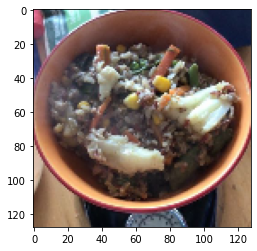

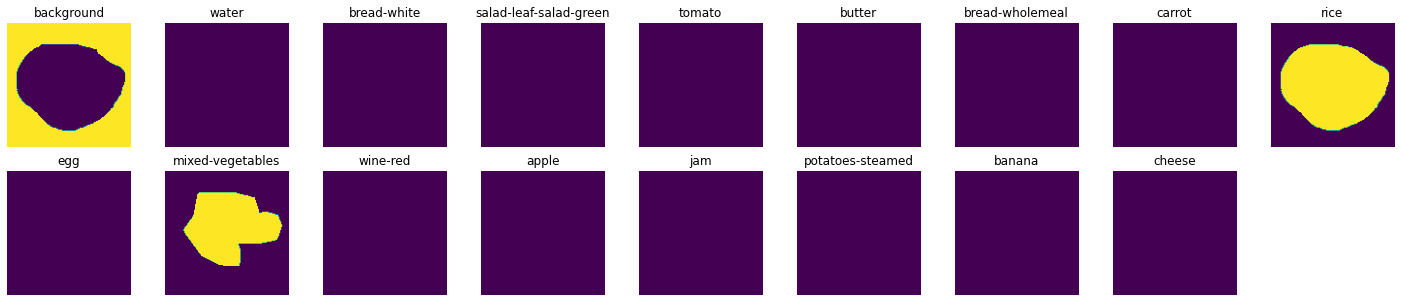

In [38]:
image_id = 1
img_folder = '{}/{}/images'.format(folder_loc, 'train')
train_img = getImage(images_train[image_id], img_folder, input_image_size)
catIds = coco_train.getCatIds(catNms=classes)
mask = getBinaryMask(images_train[image_id], classes, coco_train, catIds, input_image_size)
plt.imshow(train_img)
display_binary_masks(mask)

In [39]:

pix_per_class = [0 for i in range(number_of_classes)]
for i in range(len(images_train)):
  mask = getNormalMask(images_train[i], classes, coco_train, catIds, input_image_size)
  for j in range(number_of_classes):
    pix_per_class[j]+=np.sum(mask==j)
total_pixels = np.sum(pix_per_class)
class_weights=(total_pixels/(np.array(pix_per_class)*number_of_classes)).astype(np.float32)


In [40]:
print(class_weights)
print(class_weights.dtype)

[ 0.07833115  1.3915758   1.7474502   1.5653142   4.8239875   6.8252497
  2.9123778   4.9336624   4.513155    5.7124023   4.8385496   7.7274456
  4.691671    6.994047    8.809404    8.414779   12.061151  ]
float32


In [41]:
augGeneratorArgs = dict(featurewise_center = False, 
                        samplewise_center = False,
                        rotation_range = 5, 
                        width_shift_range = 0.01, 
                        height_shift_range = 0.01, 
                        brightness_range = (0.8,1.2),
                        shear_range = 0.01,
                        zoom_range = [1, 1.25],  
                        horizontal_flip = True, 
                        vertical_flip = False,
                        fill_mode = 'reflect',
                        data_format = 'channels_last')

train_gen_aug = augmentationsGenerator(train_gen, augGeneratorArgs)

In [ ]:
device_name = tf.test.gpu_device_name()
print(device_name)
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [42]:
from tensorflow.keras.activations import softmax
from typing import Callable, Union
def box_iou_weighted (class_weights: Union[list, np.ndarray, tf.Tensor]) -> Callable[[tf.Tensor, tf.Tensor], tf.Tensor]:
  """
  a simple Intersection over union loss for the bounding boxes produced by the region proposal network 
  :param class_weights: Class weight coefficients (Union[list, np.ndarray, tf.Tensor], len=<N_CLASSES>)
  :return: Weighted intersection over union (Callable[[tf.Tensor, tf.Tensor], tf.Tensor])
  """
  if not isinstance(class_weights, tf.Tensor):
    class_weights = tf.constant(class_weights)
  def box_iou(set1, set2):
    #res_weight=tf.reshape(class_weights[1:],shape=(1,tf.shape(class_weights)[0]-1))
    x_min = tf.math.maximum(set1[:, 0], set2[:,:, 0])
    y_min = tf.math.maximum(set1[:, 1], set2[:,:, 1])
    x_max = tf.math.minimum(set1[:, 2], set2[:,:, 2])
    y_max = tf.math.minimum(set1[:, 3], set2[:,:, 3])
    dx = tf.math.maximum(x_max - x_min, 0)
    dy = tf.math.maximum(y_max - y_min, 0)
    return 1-tf.math.reduce_mean(dx * dy/((set1[:, 2]-set1[:, 0])*(set1[:, 3]-set1[:, 1])+(set2[:,:, 2]-set2[:,:, 0])*(set2[:,:, 3]-set2[:,:, 1])-dx*dy))
  return box_iou


In [43]:
from losses import multiclass_weighted_tanimoto_loss,multiclass_weighted_dice_loss,multiclass_weighted_squared_dice_loss,multiclass_weighted_cross_entropy,multiclass_focal_loss

In [44]:
import segmentation_models as sm
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5) ]

Segmentation Models: using `tf.keras` framework.


In [ ]:

n_epochs = 10

steps_per_epoch = dataset_size_train // batch_size
validation_steps = dataset_size_val // batch_size
#lossFn = weightedLoss(tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),class_weights)
#lossFn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
lossFn = {"class_output":multiclass_weighted_squared_dice_loss(class_weights),'rpn_output':box_iou_weighted(class_weights)}
lossWeights = {"class_output":0.7, 'rpn_output':0.3}
#lossFn = multiclass_weighted_dice_loss(class_weights)

#lossFn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
#lossFn = multifunction
# Compile model
filepath = folder_loc + '/models/model_next{epoch:02d}.hdf5'
callbacks = [
        EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00001, verbose=1),
    ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
]
rn_option=tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom = True)


model.compile(loss = lossFn, optimizer = Adam(learning_rate = 1e-4), metrics={"class_output":['accuracy',metrics],'rpn_output':['accuracy']})

history = model.fit(x = train_gen_aug,
                validation_data = val_gen,
                steps_per_epoch = steps_per_epoch,
                validation_steps = validation_steps,
                epochs = n_epochs,  
                callbacks = callbacks,
                verbose = True)


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (8, 128, 128, 17) (17 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/10
1306/1306 [==============================] - 3299s 2s/step - loss: 1.6841 - class_output_loss: 0.7355 - rpn_output_loss: 0.9486 - class_output_accuracy: 0.7366 - class_output_iou_score: 0.5538 - class_output_f1-score: 0.5644 - rpn_output_accuracy: 0.0028 - val_loss: 1.6819 - val_class_output_loss: 0.7243 - val_rpn_output_loss: 0.9575 - val_class_output_accuracy: 0.6914 - val_class_output_iou_score: 0.5252 - val_class_output_f1-score: 0.5410 - val_rpn_output_accuracy: 0.0051

Epoch 00001: val_loss improved from inf to 1.68187, saving model to /content/drive/MyDrive/segmentation_food/models/model_epoch_dice_loss_second_box_01.hdf5
Epoch 2/10
1306/1306 [==============================] - 1521s 1s/step - loss: 1.6226 - class_output_loss: 0.6629 - rpn_output_loss: 0.9597 - class_output_accuracy: 0.7631 - class_output_iou_score: 0.5244 - class_output_f1-score: 0.5434 - rpn_output_accuracy: 0.0034 - val_loss: 1.6465 - val_class_output_loss: 0.6891 - val_rpn_output_loss: 0.9574 - val

In [50]:
pred_mask=[]
val_images_ids = []
for className in classes:
    # get all images containing given categories
    catIds = coco_val.getCatIds(catNms=className)
    imgIds = coco_val.getImgIds(catIds=catIds)
    for i in imgIds:
        val_images_ids.append(i)

num_image_to_plot =3
rand = np.random.randint(0, len(images_val), num_image_to_plot)
X=np.zeros(shape=(num_image_to_plot,*input_image_size,3))
j=0
for i in rand:
  img = coco_val.loadImgs(val_images_ids[i])[0]
  image = tf.io.read_file(folder_loc + '/val/images/' + img['file_name'])
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, input_image_size)

  X[j] = image
  X[j] = X[j]/255.0

  j+=1
f=0
for i in range(len(X)):
  #plot_prediction(X[i])
  pred_mask.append(model.predict(X[i].reshape(1, input_image_size[0], input_image_size[1], 3))[0])
  

  

In [ ]:
def plot_history(history):
    
    iou = history.history['class_output_iou_score']
    val_iou = history.history['val_class_output_iou_score']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    #get the numbero of epochs
    epochs = range(len(iou))
    
    plt.title("Training and validation Iou score")
    plt.plot(epochs, iou, color='blue', label='Train')
    plt.plot(epochs, val_iou, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Iou score')
    plt.legend()
    
    _ = plt.figure()

    plt.title("Training and validation Loss")
    plt.plot(epochs, loss, color='blue', label='Train')
    plt.plot(epochs, val_loss, color='orange', label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
plot_history(history)


In [52]:
#Plots all the masks predicted by the model
def plot_predicted_masks(pred_mask):
  plt.figure(figsize=(25, 5))
  display_classes = ['background'] + classes
  for i in range(17):
    new_mask = pred_mask[:,:,:,i]
    new_mask[new_mask >= 0.5] = 1
    new_mask[new_mask < 0.5] = 0
    plt.subplot(2,9,i+1)
    plt.title(display_classes[i])
    plt.axis('off')
    plt.imshow(new_mask.reshape(input_image_size[0], input_image_size[1]))

#Plot true mask
def plot_true_mask(true_mask):
  final_mask = np.zeros((input_image_size[0], input_image_size[1]))
  for i in range(1,17):
    new_mask = true_mask[:,:,i]
    final_mask = np.maximum(new_mask, final_mask)
  return final_mask.reshape(input_image_size[0], input_image_size[1],1)

In [53]:

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

(1, 128, 128)


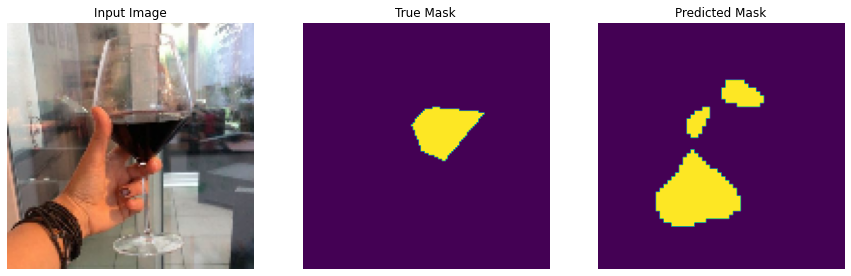

(1, 128, 128)


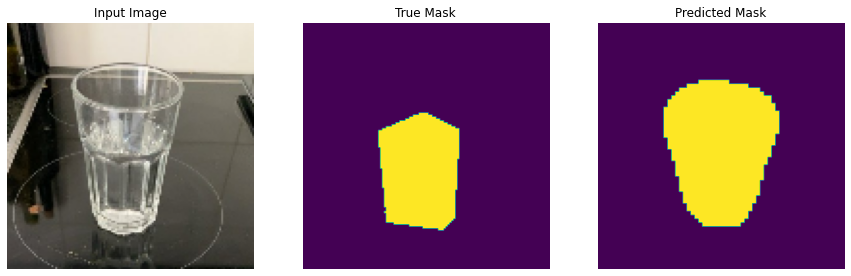

(1, 128, 128)


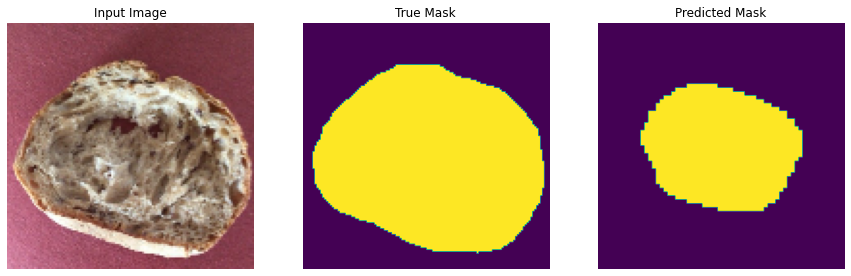

In [128]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  print(pred_mask.shape)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]
  
val_images_ids = []
for className in classes:
    # get all images containing given categories
    catIds = coco_val.getCatIds(catNms=className)
    imgIds = coco_val.getImgIds(catIds=catIds)
    for i in imgIds:
        val_images_ids.append(i)

num_image_to_plot = 3
np.random.seed(100)
rand = np.random.randint(0, len(images_val), num_image_to_plot)

X = np.zeros((num_image_to_plot, input_image_size[0], input_image_size[1], 3))

ids = [] #store here selected image ids selected in a random way 
j = 0
for i in rand:
  ids.append(val_images_ids[i])
  img = coco_val.loadImgs(val_images_ids[i])[0]
  image = tf.io.read_file(folder_loc + '/val/images/' + img['file_name'])
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, input_image_size)
  X[j] = image
  X[j] = X[j]/255.0
  j+=1
  

#Select images in order to get the true mask
images = []
for i in range(num_image_to_plot):
  for j in range(len(images_val)):
    if images_val[j]['id'] == ids[i]:
      images.append(images_val[j])

for i in range(len(X)):
  pred_mask = model.predict(X[i].reshape(1, input_image_size[0], input_image_size[1], 3))[0]
  catIds = coco_val.getCatIds(catNms=classes)
  true_mask = getBinaryMask(images[i], classes, coco_val, catIds, input_image_size)
  display([X[i], plot_true_mask(true_mask), create_mask(pred_mask)])

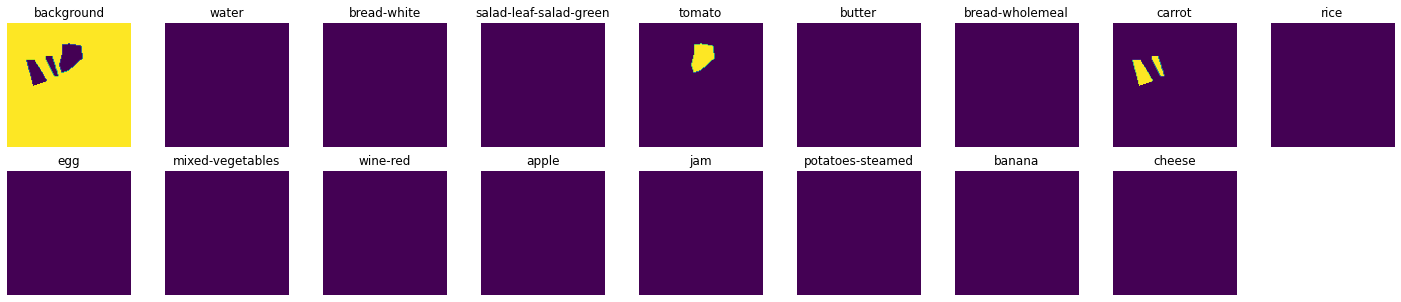

In [124]:
#TRUE BINARY MASKS

display_binary_masks(true_mask)

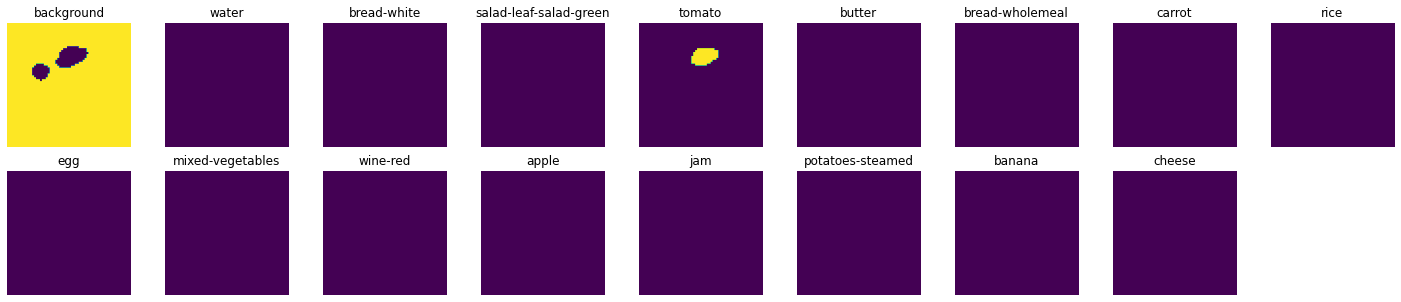

In [125]:
#PREDICTED BINARY MASKS
plot_predicted_masks(pred_mask)

In [47]:
def compute_metrics_single_image(true_mask, pred_mask):
  pred_mask[pred_mask >= 0.5] = 1
  pred_mask[pred_mask < 0.5] = 0
  #Using the IoU metric of the segmentation_models library
  iou_metric = sm.base.functional.iou_score(true_mask, pred_mask, backend = K)
  iou = np.round(iou_metric, decimals=2)
  
  true_mask = true_mask.reshape(1, input_image_size[0], input_image_size[1],17)
  precision_metric = tf.keras.metrics.Precision()
  recall_metric = tf.keras.metrics.Recall()

  precision_metric.update_state(true_mask, pred_mask)
  precision = np.round(precision_metric.result(), decimals=2)
  
  recall_metric.update_state(true_mask, pred_mask)
  recall = np.round(recall_metric.result(), decimals=2)

  return iou, precision, recall

In [48]:
def evaluation(model, data_gen):
  iou_scores = []
  precision_scores = []
  recall_scores = []  

  for i in range(dataset_size_val):
    img, true_mask = next(data_gen)
    true_mask=true_mask[0]
    pred_mask = model.predict(img)[0]
    iou, precision, recall = compute_metrics_single_image(true_mask,pred_mask)
    iou_scores.append(iou)
    precision_scores.append(precision)
    recall_scores.append(recall)

  average_iou = np.mean(iou_scores)
  average_precision = np.mean(precision_scores)
  average_recall = np.mean(recall_scores)

  return average_iou, average_precision, average_recall


# **Loading weights of different models and compare them**


*   Loss function: multiclass weighted squared dice loss
*   Batch_size: 8



In [ ]:
model.load_weights(folder_loc+'/models/model_squared_dice_6+03.hdf5')

In [ ]:
evaluation_gen = dataGeneratorCoco(images_val, classes, coco_val, folder_loc, input_image_size, 1, 'val', mask_type)
average_iou, average_precision, average_recall = evaluation(model, evaluation_gen)

In [ ]:
print(f"Mean IoU = {average_iou:.2f}, precision={average_precision:.2f}, recall = {average_recall:.2f}")

Mean IoU = 0.89, precision=0.80, recall = 0.73


# **Model 2**


*   Loss function: multiclass dice loss 
*   Batch_size: 8



In [ ]:
model.load_weights(folder_loc+'/models/model_epoch09.hdf5')

In [ ]:
evaluation_gen = dataGeneratorCoco(images_val, classes, coco_val, folder_loc, input_image_size, 1, 'val', mask_type)
average_iou, average_precision, average_recall = evaluation(model, evaluation_gen)

In [ ]:
print(f"Mean IoU = {average_iou:.2f}, precision={average_precision:.2f}, recall = {average_recall:.2f}")

Mean IoU = 0.91, precision=0.74, recall = 0.73


# **Model 3**


*   Loss function: multiclass crossentropy 
*   Batch_size: 8




In [51]:
model.load_weights(folder_loc+'/models/model_epoch08.hdf5')

In [52]:
evaluation_gen = dataGeneratorCoco(images_val, classes, coco_val, folder_loc, input_image_size, 1, 'val', mask_type)
average_iou, average_precision, average_recall = evaluation(model, evaluation_gen)

In [53]:
print(f"Mean IoU = {average_iou:.2f}, precision={average_precision:.2f}, recall = {average_recall:.2f}")

Mean IoU = 0.68, precision=0.64, recall = 0.59


# **Model 4**


*   Loss function: multiclass focal loss
*   Batch_size: 8


In [54]:
model.load_weights(folder_loc+'/models/best_focal_loss.hdf5')

In [55]:
evaluation_gen = dataGeneratorCoco(images_val, classes, coco_val, folder_loc, input_image_size, 1, 'val', mask_type)
average_iou, average_precision, average_recall = evaluation(model, evaluation_gen)

In [56]:
print(f"Mean IoU = {average_iou:.2f}, precision={average_precision:.2f}, recall = {average_recall:.2f}")

Mean IoU = 0.82, precision=0.83, recall = 0.08
